In [11]:
import anndata as ad
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import polars as pl
import mudata
import os
import gseapy
mudata.set_options(pull_on_update=False)

In [12]:
acc2gene = pd.read_table('external_data/acc2name.txt', sep='\t', header=None)
acc2gene.columns = ['acc', 'name']
acc2gene.index = acc2gene['acc']
del acc2gene['acc']
acc2gene = acc2gene.to_dict()['name']
gene2acc = {v: k for k, v in acc2gene.items()}
tid2gid = pd.read_table('external_data/gid2tid.txt', sep='\t', header=None)
tid2gid.columns = ['gid', 'tid']
tid2gid.index = tid2gid['tid']
del tid2gid['tid']
tid2gid = tid2gid.to_dict()['gid']
gid2tid = {v:k for k,v in tid2gid.items()}

In [13]:
cerr = mudata.read_h5mu("mudata/cerr/scNMT.h5mu")
annotation = pd.read_csv("external_data/sra-scNMT_cerrizuela2022_metadata.tsv", sep='\t', index_col=0)
# Subset annotation df to remove 'scNOMe-seq' lines, as both name & name-scNOME-seq are same cells obviously.
annotation = annotation[~annotation['name'].str.contains('scNOM')]
annotation.index = annotation['name']
annotation = annotation[['acc', 'cell_type', 'tissue', 'treatment']]

newix = []
for _ in cerr.var.index:
    if _ in acc2gene:
        newix.append(acc2gene[_])
    else:
        newix.append(_)
cerr.var.index = newix
newix = []
for _ in cerr['RNA'].var.index:
    if _ in acc2gene:
        newix.append(acc2gene[_])
    else:
        newix.append(_)
cerr['RNA'].var.index = newix
cerr['RNA'].var_names_make_unique()
cerr.raw = cerr.copy()
cerr.obs = annotation.loc[cerr.obs_names]
for _mod in ['RNA', 'ACC', 'METH']:
    cerr[_mod].obs = annotation.loc[cerr.obs_names]
cerr = cerr[cerr.obs['treatment'] == 'naive']

In [14]:
sc.pp.normalize_total(cerr['RNA'])
sc.pp.log1p(cerr['RNA'])

/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


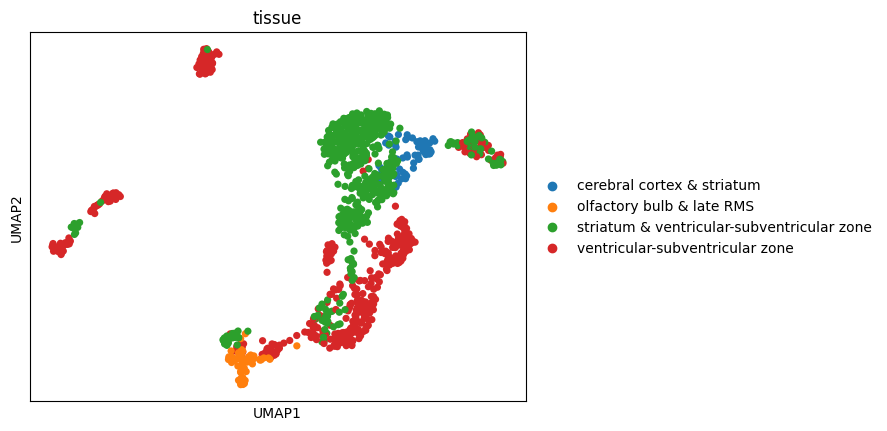

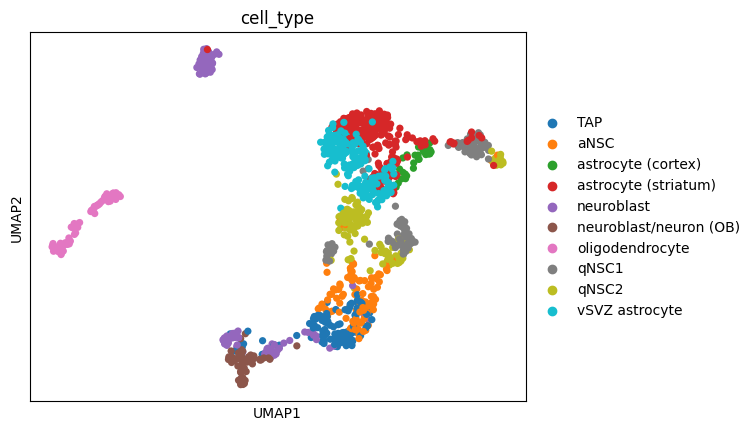

In [15]:
sc.pp.highly_variable_genes(cerr['RNA'], n_top_genes=8000)
sc.pp.pca(cerr['RNA'])

# Compute nearest neighbors (needed for UMAP)
sc.pp.neighbors(cerr['RNA'], n_neighbors=30, n_pcs=50)

# Compute UMAP
sc.tl.umap(cerr['RNA'])
sc.pl.umap(cerr['RNA'], color='tissue', save='cerr_rna_tissue.png')
sc.pl.umap(cerr['RNA'], color='cell_type', save='cerr_rna_celltype.png')

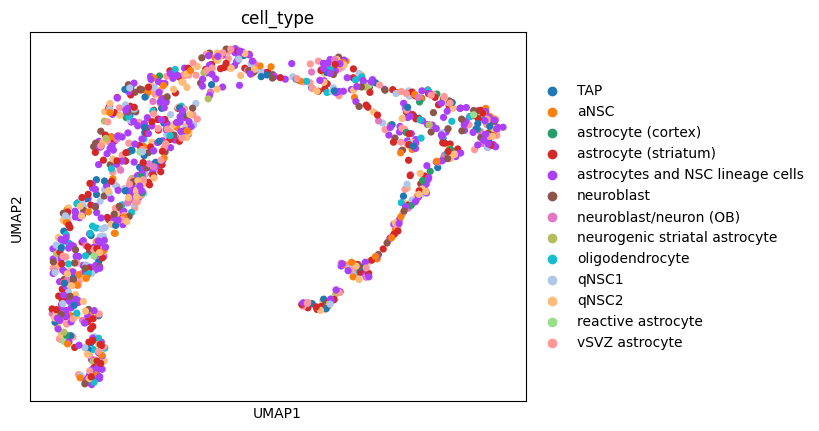

In [16]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

methdata = cerr['METH'].copy()
_ = methdata
X_bin = (_.X > 0).astype(int)
X_log = X_bin * (1e4 / X_bin.sum(axis=1)[:, None])
X_log = np.log1p(X_log)
svd = TruncatedSVD(n_components=10, random_state=0)
methdata.obsm["X_lsi"] = svd.fit_transform(X_log)
sc.pp.neighbors(methdata, use_rep="X_lsi", n_neighbors=20)
sc.tl.umap(methdata)
sc.tl.leiden(methdata, resolution=0.5)
sc.pl.umap(methdata,  color='cell_type')

# Cell Annotation part

In [17]:
def getperf(y_true, y_pred, algo=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    report = classification_report(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", conf_matrix)
    return [algo, accuracy, precision, recall, f1]
classification_results = [['algo', 'acc', 'precision', 'recall', 'F1']]

In [18]:
import celltypist
from celltypist import models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
models.download_models(force_update = False)

📂 Storing models in /home/deboutte/.celltypist/data/models
⏩ Skipping [1/54]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/54]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/54]: Adult_COVID19_PBMC.pkl (file exists)
⏩ Skipping [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [5/54]: Adult_Human_MTG.pkl (file exists)
⏩ Skipping [6/54]: Adult_Human_PancreaticIslet.pkl (file exists)
⏩ Skipping [7/54]: Adult_Human_PrefrontalCortex.pkl (file exists)
⏩ Skipping [8/54]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [9/54]: Adult_Human_Vascular.pkl (file exists)
⏩ Skipping [10/54]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [11/54]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [12/54]: Adult_Pig_Hippocampus.pkl (file exists)
⏩ Skipping [13/54]: Adult_RhesusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [14/54]: Autopsy_COVID19_Lung.pkl (file exists)
⏩ Skipping [15/54]: COVID19_HumanChallenge_Blood.pkl (file exists)
⏩ Skipping [16/54]: COVID19_Immune_La

In [19]:
model = models.Model.load(model = 'Mouse_Whole_Brain.pkl')
_ = cerr['RNA']
sc.pp.normalize_total(_, target_sum=10000)
sc.pp.log1p(_)
predictions = celltypist.annotate(_, model = model, majority_voting = True)

🔬 Input data has 1109 cells and 55401 genes
🔗 Matching reference genes in the model
🧬 5571 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [20]:
celltypist_mapper = {
    '319 Astro-TE NN': 'astrocyte',
    '045 OB-STR-CTX Inh IMN': 'immature',
    '327 Oligo NN': 'oligodendrocyte',
    '313 CBX Purkinje Gaba': 'neuron',
    '042 OB-out Frmd7 Gaba': 'neuron'
}
facs_mapper = {
    'vSVZ astrocyte': 'astrocyte',
    'qNSC2': 'immature',
    'neuroblast': 'immature',
    'aNSC': 'immature',
    'TAP': 'immature',
    'qNSC1': 'immature',
    'astrocyte (cortex)': 'astrocyte',
    'oligodendrocyte': 'oligodendrocyte',
    'neuroblast/neuron (OB)': 'neuron',
    'astrocyte (striatum)': 'astrocyte'
}

celltypist_results = pd.merge(predictions.predicted_labels, annotation, left_index=True, right_index=True)[['cell_type', 'tissue', 'majority_voting']]
celltypist_results['majority_voting_mapped'] = celltypist_results['majority_voting'].map(celltypist_mapper)
celltypist_results['celltype_mapped'] = celltypist_results['cell_type'].map(facs_mapper)
cerr['RNA'].obs['true cell_type'] = cerr['RNA'].obs['cell_type'].map(facs_mapper)
cerr['RNA'].obs['celltypist_pred'] = celltypist_results['majority_voting_mapped']
classification_results.append(getperf(celltypist_results['celltype_mapped'], celltypist_results['majority_voting_mapped'], 'celltypist'))

Accuracy: 0.7303877366997295
Precision: 0.7646734133915423
Recall: 0.7303877366997295
F1 Score: 0.712695976334357

Classification Report:
                  precision    recall  f1-score   support

      astrocyte       0.65      1.00      0.79       436
       immature       0.87      0.53      0.66       545
         neuron       0.35      0.20      0.26        55
oligodendrocyte       1.00      1.00      1.00        73

       accuracy                           0.73      1109
      macro avg       0.72      0.68      0.68      1109
   weighted avg       0.76      0.73      0.71      1109


Confusion Matrix:
 [[435   1   0   0]
 [234 291  20   0]
 [  0  44  11   0]
 [  0   0   0  73]]


# Azimuth

... storing 'true cell_type' as categorical
... storing 'celltypist_pred' as categorical


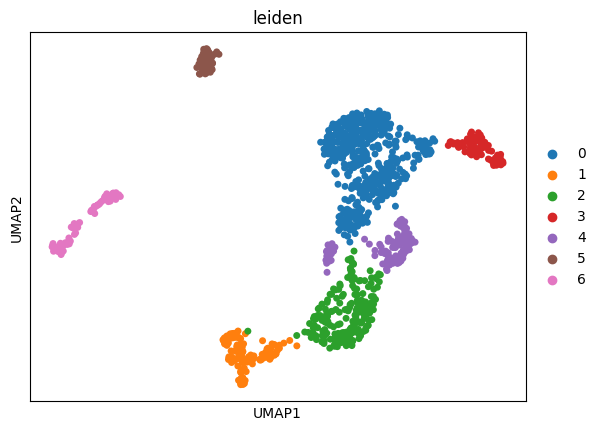

In [21]:
sc.tl.leiden(cerr['RNA'], resolution=0.2, flavor="igraph", n_iterations=2)
sc.tl.umap(cerr['RNA'])
sc.pl.umap(cerr['RNA'], color=['leiden'], size=100)

In [22]:
sc.tl.rank_genes_groups(cerr['RNA'], "leiden", method="wilcoxon")

In [23]:
azimut_ref = {}
with open('celltype_ass/azimuth_neuralref.txt') as f:
    for line in f:
        azimut_ref[line.strip().split('\t')[0]] = [i.strip() for i in line.strip().split('\t')[3].split(',')]

In [24]:
cluster_expression = cerr['RNA'].to_df().groupby(cerr['RNA'].obs['leiden']).mean()
cluster_scores = pd.DataFrame(index=cluster_expression.index)

for celltype, markers in azimut_ref.items():
    valid_markers = [gene for gene in markers if gene in cluster_expression.columns]
    if valid_markers:
        cluster_scores[celltype] = cluster_expression[valid_markers].mean(axis=1)
    else:
        cluster_scores[celltype] = np.nan
best_labels = cluster_scores.idxmax(axis=1)
cerr['RNA'].obs['azimuth_pred'] = cerr['RNA'].obs['leiden'].map(best_labels)

In [25]:
azimut_mapper = {
    'Astro': 'astrocyte',
    'Meis2': 'Neuron',
    'Oligo': 'oligodendrocyte',
    'L5/6 NP': 'Neuron'
}
facs_mapper = {
    'vSVZ astrocyte': 'astrocyte',
    'qNSC2': 'immature',
    'neuroblast': 'immature',
    'aNSC': 'immature',
    'TAP': 'immature',
    'qNSC1': 'immature',
    'astrocyte (cortex)': 'astrocyte',
    'oligodendrocyte': 'oligodendrocyte',
    'neuroblast/neuron (OB)': 'neuron',
    'astrocyte (striatum)': 'astrocyte'
}
cerr['RNA'].obs['azimuth_pred'] = cerr['RNA'].obs['azimuth_pred'].map(azimut_mapper)
classification_results.append( getperf(cerr['RNA'].obs['true cell_type'], cerr['RNA'].obs['azimuth_pred'], 'azimuth') )

Accuracy: 0.4580703336339044
Precision: 0.2608295556311838
Recall: 0.4580703336339044
F1 Score: 0.3263261125307925

Classification Report:
                  precision    recall  f1-score   support

         Neuron       0.00      0.00      0.00         0
      astrocyte       0.50      1.00      0.66       436
       immature       0.00      0.00      0.00       545
         neuron       0.00      0.00      0.00        55
oligodendrocyte       1.00      1.00      1.00        73

       accuracy                           0.46      1109
      macro avg       0.30      0.40      0.33      1109
   weighted avg       0.26      0.46      0.33      1109


Confusion Matrix:
 [[  0   0   0   0   0]
 [  1 435   0   0   0]
 [103 442   0   0   0]
 [ 55   0   0   0   0]
 [  0   0   0   0  73]]


# Map my cells

In [29]:
mmc_mapper = {
    '30 Astro-Epen': 'astrocyte',
    '05 OB-IMN GABA': 'immature',
    '04 DG-IMN Glut': 'immature',
    '24 MY Glut': 'neuron',
    '31 OPC-Oligo': 'oligodendrocyte',
    '32 OEC': 'neuron',
    '10 LSX GABA': 'neuron'
}
mmc_res = cerr['RNA'].obs[['cell_type']].copy()
mmc_res['cell_type_truth'] = mmc_res['cell_type'].map(facs_mapper)
mmc_csv = pd.read_csv('celltype_ass/mapmycells.csv', comment='#')
mmc_csv.index = mmc_csv['cell_id']
mmc_csv = mmc_csv[['class_name']]
mmc = pd.merge(mmc_res, mmc_csv, left_index=True, right_index=True)
mmc['mmc_class'] = mmc['class_name'].map(mmc_mapper)
cerr['RNA'].obs['map_my_cells_pred'] = mmc['mmc_class']

classification_results.append( 
   getperf(mmc['cell_type_truth'], mmc['mmc_class'], 'map_my_cells')
)

Accuracy: 0.7448151487826871
Precision: 0.7686699077884627
Recall: 0.7448151487826871
F1 Score: 0.720135665377443

Classification Report:
                  precision    recall  f1-score   support

      astrocyte       0.66      1.00      0.79       436
       immature       0.85      0.58      0.69       545
         neuron       0.50      0.04      0.07        55
oligodendrocyte       1.00      1.00      1.00        73

       accuracy                           0.74      1109
      macro avg       0.75      0.65      0.64      1109
   weighted avg       0.77      0.74      0.72      1109


Confusion Matrix:
 [[435   1   0   0]
 [227 316   2   0]
 [  0  53   2   0]
 [  0   0   0  73]]


# Cellmarker2.0

In [30]:
cellmarker_ref = {}
with open('celltype_ass/cellmarker2.csv', encoding='utf-8-sig') as f:
    for line in f:
        cellmarker_ref[line.strip().split('\t')[0]] = [i.strip() for i in line.strip().split('\t')[1].split(',')]

In [31]:
cluster_expression = cerr['RNA'].to_df().groupby(cerr['RNA'].obs['leiden']).mean()
cluster_scores = pd.DataFrame(index=cluster_expression.index)

for celltype, markers in cellmarker_ref.items():
    valid_markers = [gene for gene in markers if gene in cluster_expression.columns]
    if valid_markers:
        cluster_scores[celltype] = cluster_expression[valid_markers].mean(axis=1)
    else:
        cluster_scores[celltype] = np.nan
best_labels = cluster_scores.idxmax(axis=1)
cerr['RNA'].obs['cellmarker2_pred'] = cerr['RNA'].obs['leiden'].map(best_labels)

In [32]:
cellmarker_mapper = {
    'astrocyte': 'astrocyte',
    'layerneuron': 'neuron',
    'interm_progenitor': 'immature',
    'neuron': 'neuron'
}
cerr['RNA'].obs['cellmarker2_pred'] = cerr['RNA'].obs['cellmarker2_pred'].map(cellmarker_mapper)
classification_results.append(
    getperf(cerr['RNA'].obs['true cell_type'], cerr['RNA'].obs['cellmarker2_pred'], 'cellmarker2.0')
)

Accuracy: 0.6113615870153292
Precision: 0.8340995858470506
Recall: 0.6113615870153292
F1 Score: 0.6322356612858965

Classification Report:
                  precision    recall  f1-score   support

      astrocyte       0.85      0.97      0.91       436
       immature       1.00      0.37      0.53       545
         neuron       0.13      1.00      0.23        55
oligodendrocyte       0.00      0.00      0.00        73

       accuracy                           0.61      1109
      macro avg       0.50      0.58      0.42      1109
   weighted avg       0.83      0.61      0.63      1109


Confusion Matrix:
 [[424   0  12   0]
 [ 72 199 274   0]
 [  0   0  55   0]
 [  0   0  73   0]]


# Decoupler

In [33]:
import decoupler as dc

In [34]:
markers = dc.get_resource(
    name='PanglaoDB',
    organism='mouse',
    license='academic'
)
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['mouse_sensitivity'].astype(float) > 0.5)]
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]

In [35]:
dc.run_ora(
    mat=cerr['RNA'],
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

21524 features of mat are empty, they will be removed.
Running ora on mat with 1109 samples and 33877 targets for 80 sources.


100%|██████████| 1109/1109 [00:04<00:00, 260.67it/s]


In [36]:
cerr['RNA'].obs['decoupler_pred'] = cerr['RNA'].obsm['ora_estimate'].idxmax(axis=1)
decoupler_mapper = {
    'Müller cells': 'muller cells',
    'Astrocytes': 'astrocytes',
    'Neuroblasts': 'immature',
    'Neural stem/precursor cells': 'immature',
    'Neurons': 'neuron',
    'Bergmann glia': 'glia',
    'Radial glia cells': 'glia',
    'Hematopoietic stem cells': 'immature',
    'Oligodendrocytes': 'oligodendrocyte',
    'Immature neurons': "immature",
    'Monocytes': "monocytes",
    'Tanycytes': "tanycytes",
    'Alpha cells': "alpha cells",
    'Cardiomyocytes': "cardiomyocytes"
}

cerr['RNA'].obs['decoupler_pred'] = cerr['RNA'].obs['decoupler_pred'].map(decoupler_mapper)
classification_results.append(
    getperf( cerr['RNA'].obs['cell_type'].map(facs_mapper), cerr['RNA'].obs['decoupler_pred'], 'decoupler')
)

Accuracy: 0.16411181244364292
Precision: 0.4966254461124904
Recall: 0.16411181244364292
F1 Score: 0.20453450211208163

Classification Report:
                  precision    recall  f1-score   support

    alpha cells       0.00      0.00      0.00         0
      astrocyte       0.00      0.00      0.00       436
     astrocytes       0.00      0.00      0.00         0
 cardiomyocytes       0.00      0.00      0.00         0
           glia       0.00      0.00      0.00         0
       immature       0.85      0.14      0.24       545
      monocytes       0.00      0.00      0.00         0
   muller cells       0.00      0.00      0.00         0
         neuron       0.30      0.58      0.40        55
oligodendrocyte       1.00      1.00      1.00        73
      tanycytes       0.00      0.00      0.00         0

       accuracy                           0.16      1109
      macro avg       0.20      0.16      0.15      1109
   weighted avg       0.50      0.16      0.20      1109


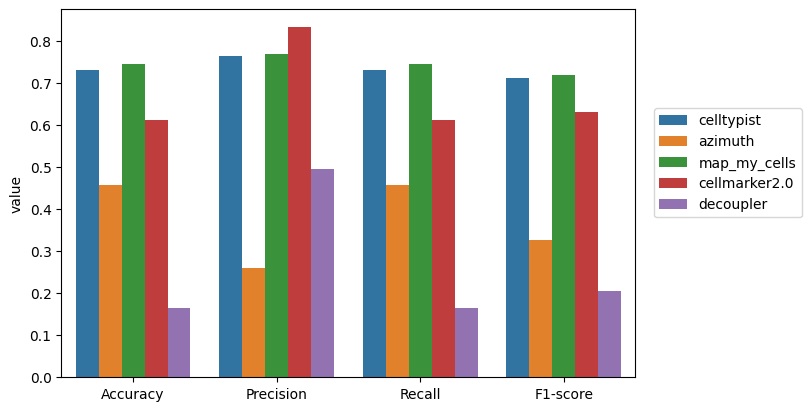

In [37]:
cell_type_class = pd.DataFrame(classification_results[1::])
cell_type_class.columns = ['Method', 'Accuracy', 'Precision', 'Recall', 'F1-score']

ctc = cell_type_class.melt(id_vars='Method')
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4), constrained_layout=True)
sns.barplot(
    data=ctc,
    x='variable',
    y='value',
    hue='Method'
)
ax.legend(bbox_to_anchor=(1.02,0.75))
ax.set_ylabel('value')
ax.set_xlabel('')
fig.savefig("figures/2.3_performance.png", dpi=300)

In [38]:
cell_type_class

,Method,Accuracy,Precision,Recall,F1-score
0,celltypist,0.730388,0.764673,0.730388,0.712696
1,azimuth,0.458070,0.260830,0.458070,0.326326
2,map_my_cells,0.744815,0.768670,0.744815,0.720136
3,cellmarker2.0,0.611362,0.834100,0.611362,0.632236
4,decoupler,0.164112,0.496625,0.164112,0.204535


... storing 'azimuth_pred' as categorical
... storing 'map_my_cells_pred' as categorical
... storing 'cellmarker2_pred' as categorical
... storing 'decoupler_pred' as categorical


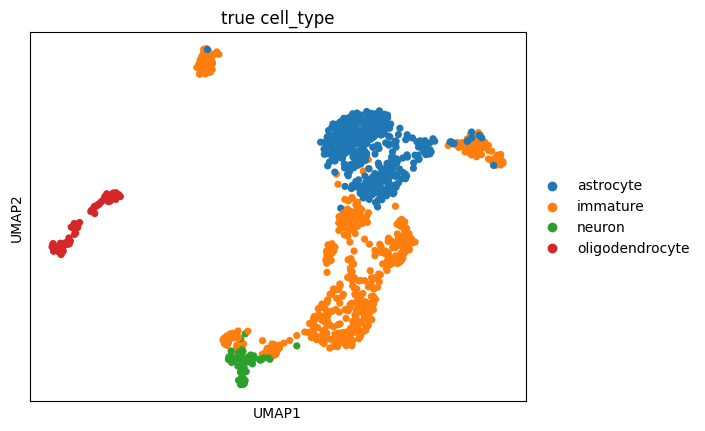

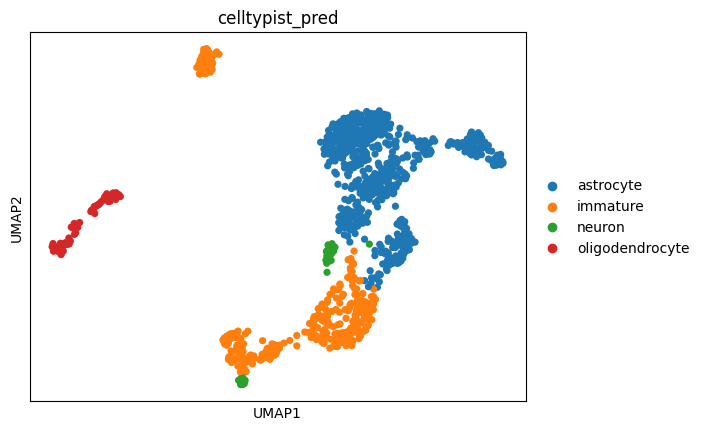

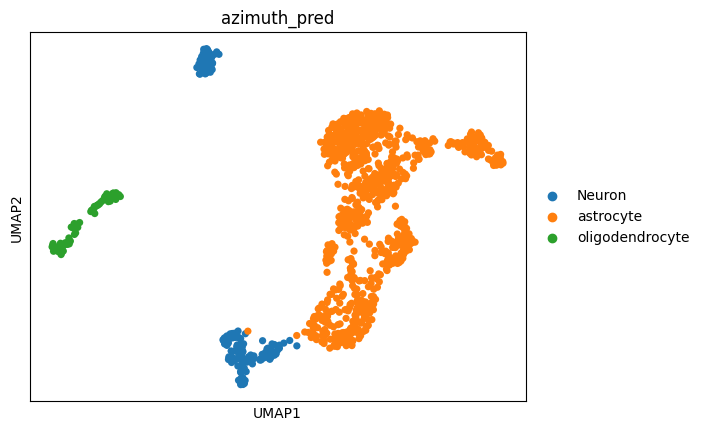

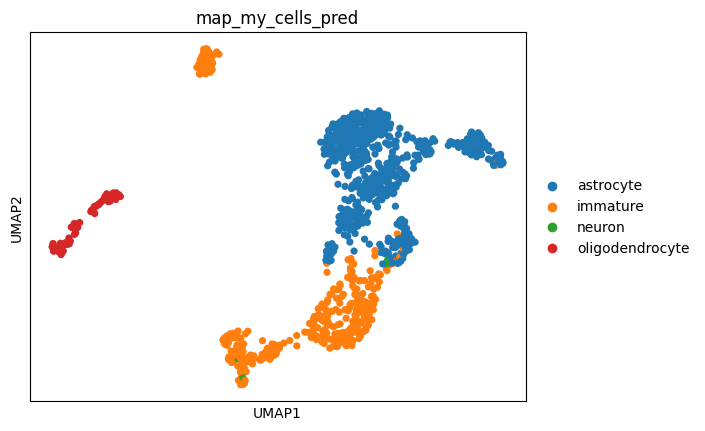

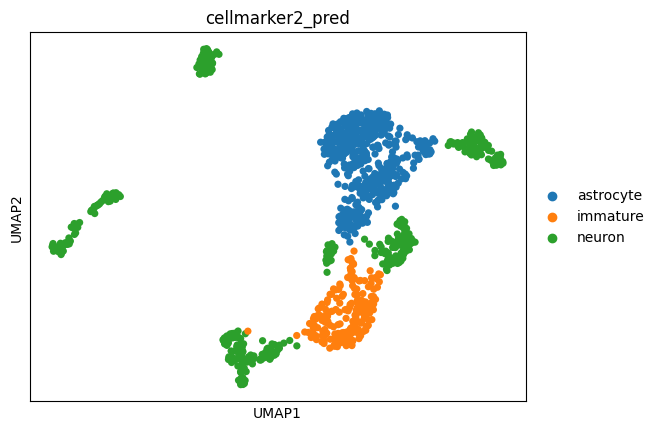

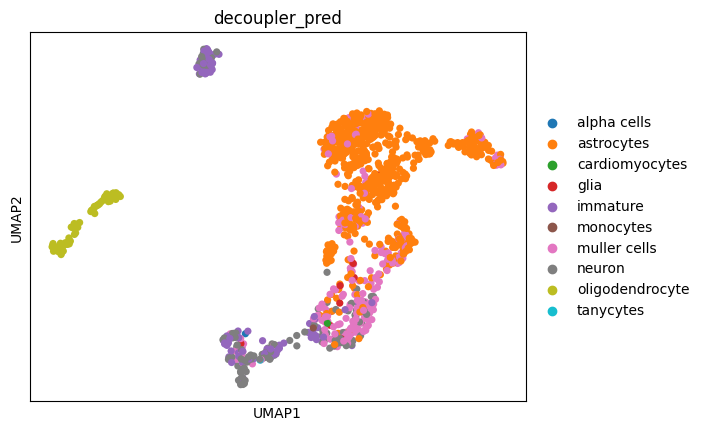

In [39]:
cerr['RNA'].obs
sc.pl.umap(cerr['RNA'], color='true cell_type', save='pred_true.png')
sc.pl.umap(cerr['RNA'], color='celltypist_pred', save='pred_celltypist.png')
sc.pl.umap(cerr['RNA'], color='azimuth_pred', save='pred_azimuth.png')
sc.pl.umap(cerr['RNA'], color='map_my_cells_pred', save='pred_mapmycells.png')
sc.pl.umap(cerr['RNA'], color='cellmarker2_pred', save='pred_cellmarker2.png')
sc.pl.umap(cerr['RNA'], color='decoupler_pred', save='pred_decoupler.png')

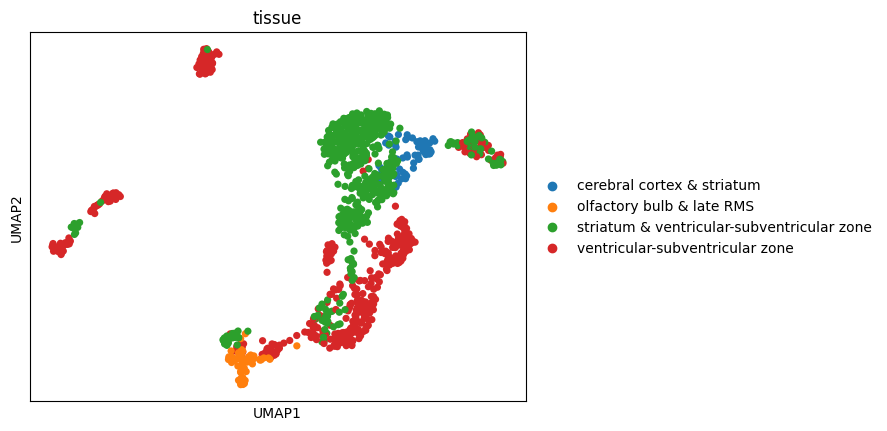

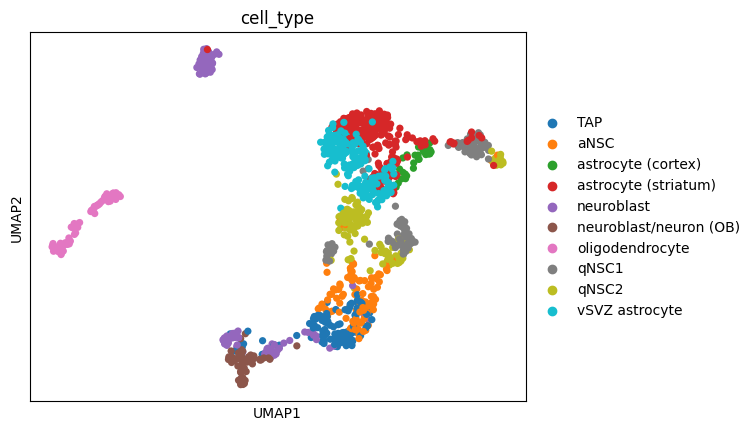

In [40]:
sc.pl.umap(cerr['RNA'], color='tissue', save='cerr_rna_tissue.png')
sc.pl.umap(cerr['RNA'], color='cell_type', save='cerr_rna_celltype.png')